In [61]:
import pandas as pd
import numpy as np
import datetime
from .HuobiServices import *
from .DataUtils import *
import talib
import statsmodels.api as sm
from statsmodels import regression
import seaborn as sns
from collections import OrderedDict
%matplotlib inline

In [6]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
zscore=lambda x:(x-np.mean(x,axis=1))/np.std(x,axis=1)

In [7]:
def kline(asset,interval='15min',count=500):
    s=get_kline('{0}btc'.format(asset),interval,count)
    if s is None: return None
    s=s['data']
    s=pd.DataFrame(s)[::-1]
    if s.shape[0]<count:
        return None
    s.index=pd.DatetimeIndex(s['id'].apply(lambda x:datetime.datetime.utcfromtimestamp(x) + datetime.timedelta(hours=8)))
    s=s.drop('id',axis=1)
    s['avg']=(np.mean(s[['open','high','low','close']],axis=1))
    s['diff']=np.log(s['avg']/s['avg'].shift(1)).fillna(0)
    return s

In [8]:
def find_cointegrated_pairs(dataframe):
    n = dataframe.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = dataframe.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(stock1, stock2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

In [9]:
def linreg(x,y):
#     market, asset
    x=sm.add_constant(x)
    model=regression.linear_model.OLS(y,x).fit()
    x=x[:,1]
#     alpha beta
    return model.params[0],model.params[1]

##  Fetch Data

In [10]:
symbols=lmap(lambda x:x['base-currency'],lfilter(lambda x: x['quote-currency']=='btc',get_symbols()['data']))

In [11]:
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='15min',count=2000)),symbols))

In [12]:
asset_data=pd.Panel(dict(asset_data))

In [27]:
asset_data.shape

(107, 2000, 9)

##  Manipulate Data

In [69]:
market_index=asset_data[:,:,'diff'].mean(axis=1)
market_index.name='market_index'

## Build CAPM

In [70]:
capm=pd.DataFrame(lmap(lambda x:linreg(x=market_index.values,y=asset_data[x,:,'diff'].values),asset_data.items),index=asset_data.items,columns=['alpha','beta'])

## Filter assets based on rules

In [71]:
# select high beta assets
market_related=capm[(capm['alpha']>0)&(capm['beta']>1)].sort_values('alpha')

In [72]:
# select low beta assets
market_unrelated=capm[(capm['alpha']>0)&(capm['beta']<1)].sort_values('alpha')

In [73]:
# both need higher alpha, thereby use the highest two
candidate=list(market_related[-2:].index)+list(market_unrelated[-2:].index)

In [74]:
candidate

['ven', 'ont', 'mana', 'ht']

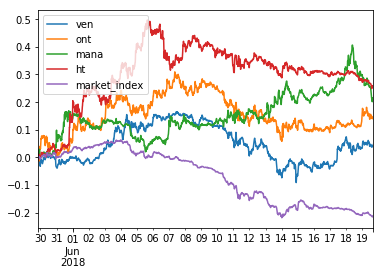

In [76]:
asset_data[candidate,:,'diff'].cumsum().join(market_index.cumsum()).plot()

## Select assets based on co-integration test

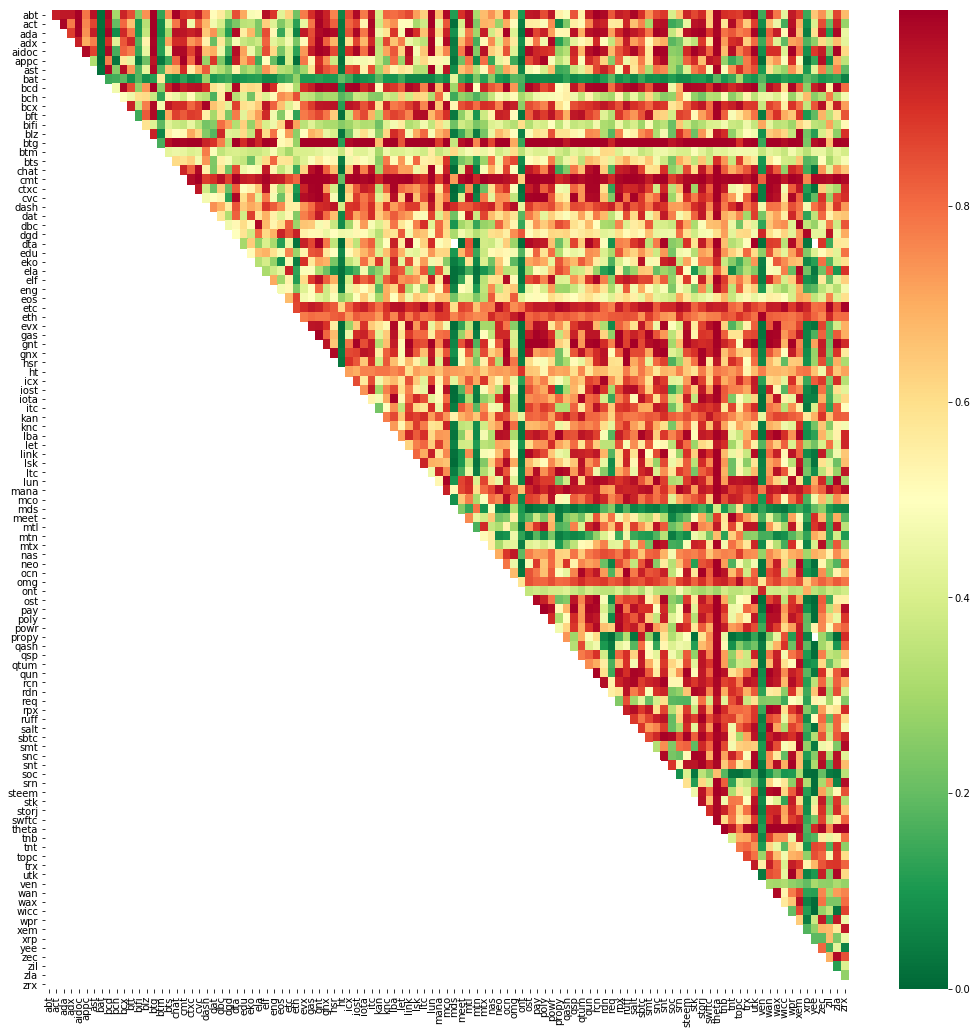

In [77]:
pvalue_matrix,pairs=find_cointegrated_pairs(asset_data[:,:,'diff'].cumsum())
pvalues_df=pd.DataFrame(pvalue_matrix,index=asset_data.items,columns=asset_data.items)
plt.figure(figsize=(18,18))
sns.heatmap(1-pvalue_matrix, xticklabels=asset_data.items, yticklabels=asset_data.items, cmap='RdYlGn_r', mask = (pvalue_matrix == 1))